In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

# DATA LOADING

In [2]:
DATA_DIR = 'data/animals/'

In [3]:
LABELS = ['cat', 'dog' , 'horse']

In [4]:
def load_data(PATH) :
    IMAGES, Y = [], []
    
    for label in LABELS :
        print('Loading images for', label)
        for file in os.listdir(PATH + label) :
            image = cv2.imread(PATH + label + '/' + file)
            image = cv2.resize(image, (128, 128))
            IMAGES.append(image)
            Y.append(LABELS.index(label))
        
    IMAGES = np.array(IMAGES).astype('float32') / 255
    Y = np.array(Y)

    return IMAGES , Y

In [5]:
TRAIN_IMAGES, TRAIN_LABELS = load_data(DATA_DIR + 'train/')

Loading images for cat
Loading images for dog
Loading images for horse


In [6]:
TEST_IMAGES, TEST_LABELS = load_data(DATA_DIR + 'val/')

Loading images for cat
Loading images for dog
Loading images for horse


In [7]:
print(TRAIN_IMAGES.shape, TRAIN_LABELS.shape)
print(TEST_IMAGES.shape, TEST_LABELS.shape)

(8069, 128, 128, 3) (8069,)
(900, 128, 128, 3) (900,)


# Network

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary

In [75]:
class AnimalClassifier(nn.Module) :
    def __init__(self, Y = len(LABELS)) :
        super(AnimalClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.fc1 = nn.Linear(128 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, Y)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x) :
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # x = x.view(-1, 128 * 14 * 14)
        x = nn.Flatten()(x)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = AnimalClassifier()
# summary(model, (3, 128, 128))

In [76]:
BATCH_SIZE = 32
EPOCHS = 10
lr = 0.001

In [77]:
# train model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()


Epoch 0 loss 4.714901522212791	797087454084e-09 		
Epoch 1 loss 2.2913062362530963595107695088e-05 		
Epoch 2 loss 1.277690594247791990076417309e-09 			
Epoch 3 loss 1.5433171146809177168867588043 		 			
Epoch 4 loss 1.230940847293190400910949707 			
Epoch 5 loss 1.1323290740548386768061637878 		
Epoch 6 loss 1.1245679754042344525295257568 		
Epoch 7 loss 1.1214203660195996792264938354 		
Epoch 8 loss 1.1182033881368374830723762512 		
Epoch 9 loss 1.115533587960857731759262085 			
Test loss 1.0979074445264092


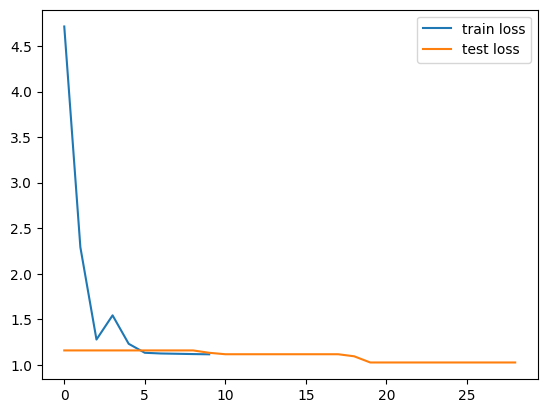

In [78]:
def train(model, X, Y, optimizer, loss_fn, batch_size=BATCH_SIZE, epochs=EPOCHS) :
    model.train()
    train_loss = []
    for epoch in range(epochs) :
        LOSS = []
        for i in range(0, len(X), batch_size) :
            x_batch = torch.tensor(X[i:i+batch_size], dtype=torch.float32).to(device)
            y_batch = torch.tensor(Y[i:i+batch_size], dtype=torch.long).to(device)
            # print(x_batch.shape)
            x_batch = x_batch.permute(0, 3, 1, 2)
            # print(x_batch.shape)
            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            print(f'\rEpoch {epoch} [{i}/{len(X)}] loss {loss.item()} \t\t', end='')
            LOSS.append(loss.item())
        print(f'\rEpoch', epoch, 'loss', np.mean(LOSS))
        train_loss.append(np.mean(LOSS))

    test_loss = []
    model.eval()
    for i in range(0, len(TEST_IMAGES), batch_size) :
        x_batch = torch.tensor(TEST_IMAGES[i:i+batch_size], dtype=torch.float32).to(device)
        y_batch = torch.tensor(TEST_LABELS[i:i+batch_size], dtype=torch.long).to(device)
        x_batch = x_batch.permute(0, 3, 1, 2)
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)
        test_loss.append(loss.item())
    print('Test loss', np.mean(test_loss))

    return model, train_loss, test_loss

model, train_loss , test_loss = train(model, TRAIN_IMAGES, TRAIN_LABELS, optimizer, loss_fn)

plt.plot(train_loss)
plt.plot(test_loss)
plt.legend(['train loss', 'test loss'])
plt.show()

# Infer

In [13]:
IMG = []
INFER_PATH = DATA_DIR + 'inf/'

tensor([[-0.4404, -0.8442, -1.6743]], device='cuda:0')
cat


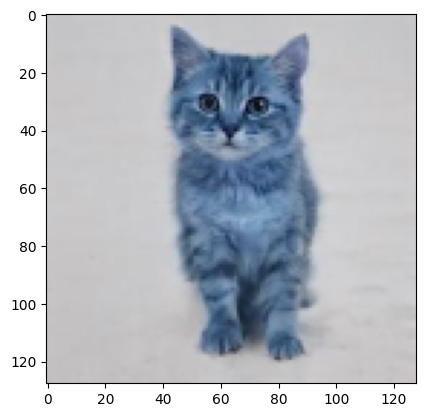

In [79]:
IMG = []
img = cv2.imread(INFER_PATH + 'cat.jpg')
img = cv2.resize(img, (128, 128))
IMG.append(img)

model.eval()
with torch.no_grad() :
    x = torch.tensor(IMG, dtype=torch.float32).to(device)
    x = x.permute(0, 3, 1, 2)
    y_pred = model(x)
    print(y_pred)
    print(LABELS[torch.argmax(y_pred).item()])
    plt.imshow(IMG[0])
    plt.show()
    